## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II
# Micro-Proyecto 1

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

A continuación escriba los nombres de los integrantes del grupo.

Nombres:


### Introducción
Una *start-up* agrícola quiere construir una aplicación online que conecte el campo
con la ciudad de manera directa y sin intermediarios. De esta manera, los agricultores ponen a la disposición de la empresa sus distintos productos, y la start-up se encarga de atender las necesidades de demanda distribuyendo los productos hasta los clientes finales en la ciudad.

Para optimizar la gestión logística y desarrollar esta labor de manera eficiente, los dueños de la *start-up* han visto la necesidad de diseñar e implementar un sistema de gestión y predicción que les permita planear con la debida anticipación la demanda esperada. Así podrán coordinar las actividades de producción, junto con los agricultores, y atender la demanda mientras se minimizan las pérdidas por unidades de producto no vendido o estropeado. 

Este es un reto altamente relevante para la sostenibilidad de la industria alimentaria, donde gran cantidad de las pérdidas se refieren a grupos alimenticios donde la frescura del producto es un importante criterio para el consumo. El desperdicio de los alimentos se relaciona con el sobre-pedido o el sobre-almacenamiento, lo cual puede a su vez ser consecuencia de dificultades en el pronóstico de la demanda. Este problema es aun más marcado a medida que uno sube en la cadena de producción y se aleja de los patrones de comportamiento del consumidor final. 

Por lo tanto, la start-up agrícola debe gestionar los inventarios de manera inteligente, disminuyendo la ventana de tiempo entre cosecha y consumo. Para ello, necesita desarrollar modelos de predicción de demanda que apoyen su operación, logrando la disponibilidad de los productos para atender a los clientes del día siguiente, minimizando los desperdicios de alimentos e identificando hábitos de consumo que le permita optimizar sus operaciones logísticas y de negocio.

### Enunciado
Por ello se le pide a usted, en calidad de consultor externo, desarrollar un modelo predictivo de demanda para los productos más relevantes con los que trabaja la start-up agrícola, obteniendo una predicción a nivel semanal (una semana adelante). Los datos los encuentra en el archivo DatosAgro.txt, donde se tiene la identificación del cliente, la fecha en que realizó el pedido, la magnitud del pedido (en unidades según lo especificado en el nombre del producto), su precio, y el código del producto agrícola que consta en el pedido.

## 1. Visualicemos los datos

In [1]:
import pandas as pd
import numpy as np
from numpy import loadtxt
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
import pandas as pd
from scipy import stats
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import missingno as msno
from datetime import datetime

import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from prettytable import PrettyTable
import datetime

import keras
import h5py
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from keras.layers import Conv1D, MaxPooling1D, Activation, Dropout, Flatten, Dense,Bidirectional
from keras import applications

from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

sns.set_style("darkgrid");

In [2]:
# Importemos los datos y visualizemos la serie de tiempo
data = pd.read_csv("5658240.txt", delimiter='\t', encoding="utf8")
data = data.drop('Unnamed: 6', 1)
data.head()

Cliente       Fecha  Pedido  Precio Producto          Nombre_producto
0  Cliente26  18/09/2017      20     700  VER0049  Yerbabuena / 100 gramos
1  Cliente26  18/09/2017      10    1200  FRU0024     Limón Tahití / Libra
2  Cliente26  18/09/2017       4    1600  VER0041           Puerro / Libra
3  Cliente26  18/09/2017      10    1500  VER0038    Pimentón Rojo / Libra
4  Cliente26  18/09/2017       8    1100  VER0010   Zucchini Verde / Libra

Veamos los clientes con mayor participación en la demanda:

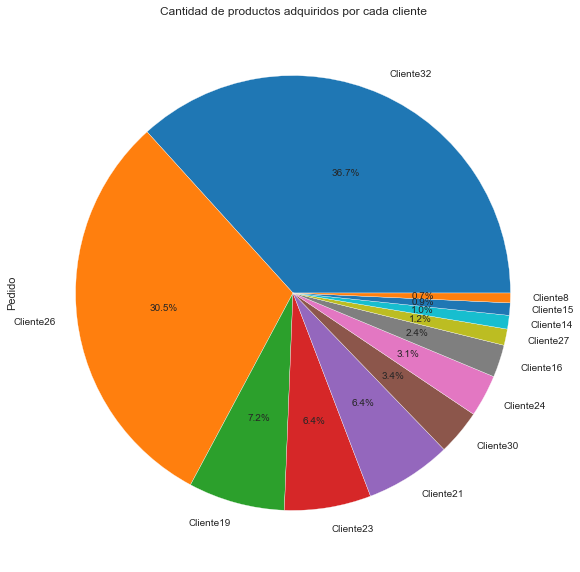

In [3]:
cliente = pd.DataFrame(data[data['Pedido'] > 10].groupby(data["Cliente"]).sum())
cliente2 = cliente[cliente['Pedido']>50]
cliente3 = cliente2.sort_values("Pedido", ascending= False)
cliente3.plot.pie(y='Pedido', figsize=(10, 10), legend=False, autopct='%1.1f%%')
plt.title("Cantidad de productos adquiridos por cada cliente")
plt.show();

Vemaos los productos con más volumen de pedido:

<AxesSubplot:ylabel='Pedido'>

Text(0.5, 1.0, 'Cantidad de productos adquiridos por producto')

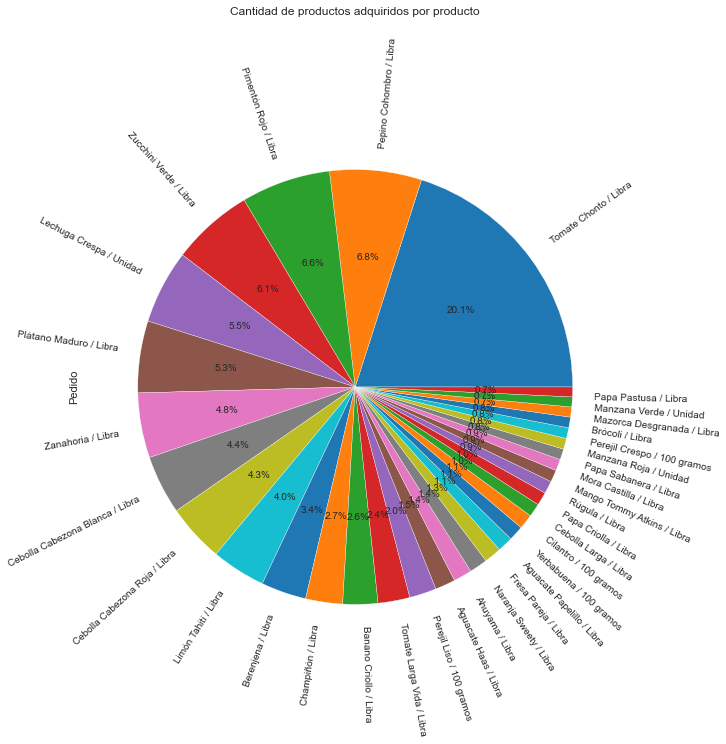

In [4]:
productos = pd.DataFrame(data["Pedido"].groupby(data["Nombre_producto"]).sum())
productos2 = productos[productos['Pedido']>140]
productos3 = productos2.sort_values("Pedido", ascending= False)
productos3.plot.pie(y='Pedido', figsize=(10, 10), legend=False, autopct='%1.1f%%', rotatelabels=True)
plt.title("Cantidad de productos adquiridos por producto", pad=100)
plt.show()

A continuación implemente la metodología propuesta para construir su modelo:

# 1. Analisis Descriptivo

Procederemos a relizar una exploracion de los datos, para observar sus particularidades.

## 1.1 Evaluación de Valores Faltantes

In [5]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4712 entries, 0 to 4711
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Cliente          4708 non-null   object
 1   Fecha            4712 non-null   object
 2   Pedido           4712 non-null   int64 
 3   Precio           4712 non-null   int64 
 4   Producto         4712 non-null   object
 5   Nombre_producto  4712 non-null   object
dtypes: int64(2), object(4)
memory usage: 221.0+ KB


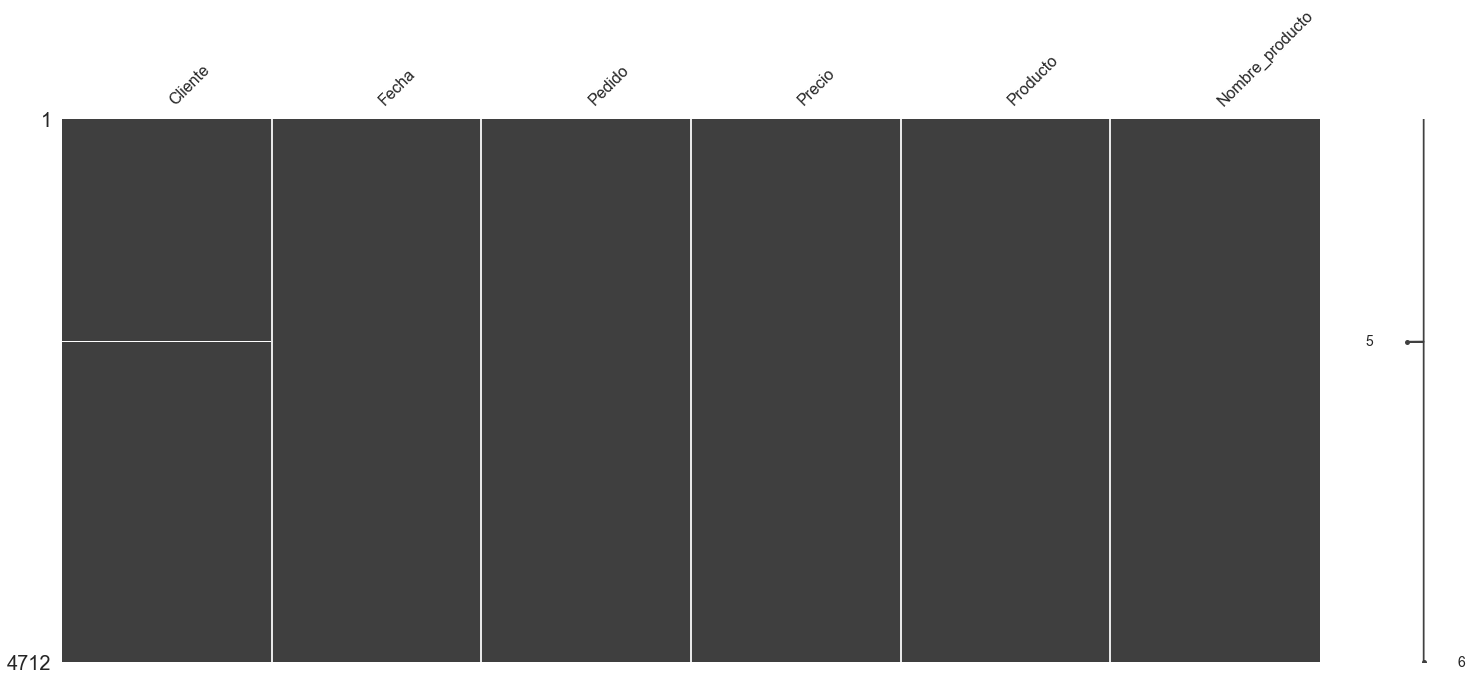

In [6]:
# Generamos un mapa con el fin de visualizar los valores faltantes (missing values)
msno.matrix(data);

Podemos ver que hay 4 valores faltantes en los datos de los clientes.

In [7]:
data[data.isna().any(axis=1)]

Cliente       Fecha  Pedido  Precio Producto  \
1932     NaN  19/06/2017      40    1450  FRU0046   
1933     NaN  19/06/2017      10    2100  VER0012   
1934     NaN  19/06/2017       8    1700  VER0038   
1935     NaN  19/06/2017       6     650  VER0035   

                      Nombre_producto  
1932            Tomate Chonto / Libra  
1933  Cebolla Cabezona Blanca / Libra  
1934            Pimentón Rojo / Libra  
1935          Pepino Cohombro / Libra

## 1.2 Revisión Variables Numericas

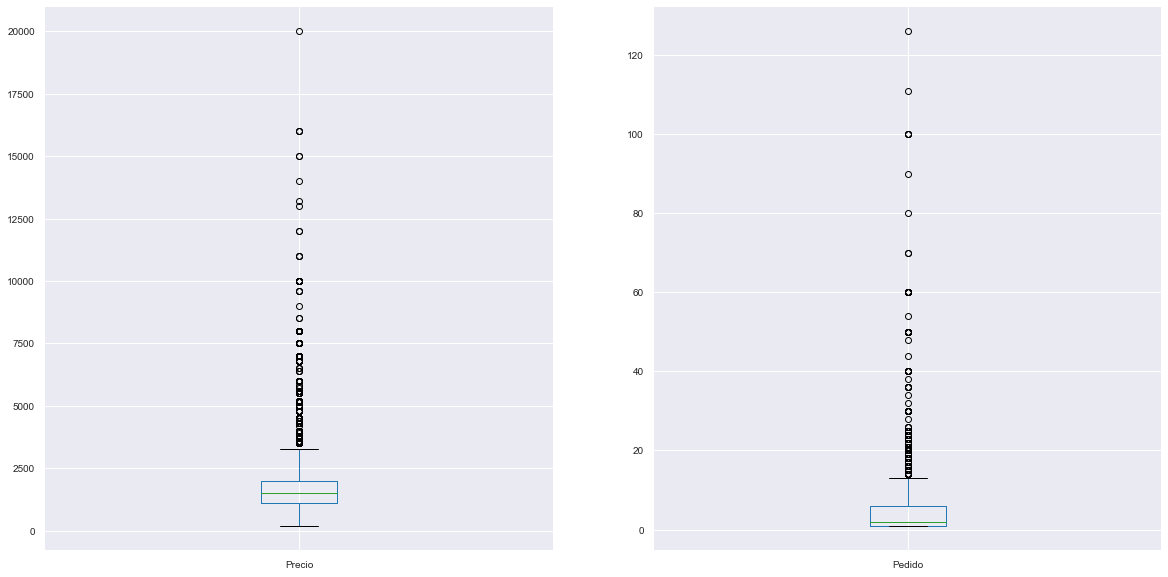

In [8]:
cols = ["Precio","Pedido"]
data[cols].plot(kind="box",subplots=True,figsize=(20, 10));

## 1.3 Revision de Variables Categoricas

In [9]:
pd.DataFrame(data["Cliente"].value_counts()).head(10)

Cliente
Cliente32      932
Cliente29      862
Cliente21      584
Cliente3       411
Cliente16      193
Cliente10      193
Cliente19      184
Cliente2       182
Cliente22      169
Cliente13      168

In [10]:
pd.DataFrame(data["Producto"].value_counts())

Producto
FRU0046       355
VER0035       223
VER0016       204
VER0028       174
VER0010       164
...           ...
VER0036         1
TUB0015         1
GRA0011         1
FRU0052         1
VER050          1

[121 rows x 1 columns]

In [11]:
pd.DataFrame(data["Nombre_producto"].value_counts())

Nombre_producto
Tomate Chonto / Libra                  355
Pepino Cohombro / Libra                223
Champiñón / Libra                      204
Lechuga Crespa / Unidad                174
Zucchini Verde / Libra                 164
...                                    ...
Toronjil                                 1
Pepino Europeo / Libra                   1
Zucchini Amarillo / Libra                1
Manzana Nacional / Libra                 1
Cubio / Libra                            1

[121 rows x 1 columns]

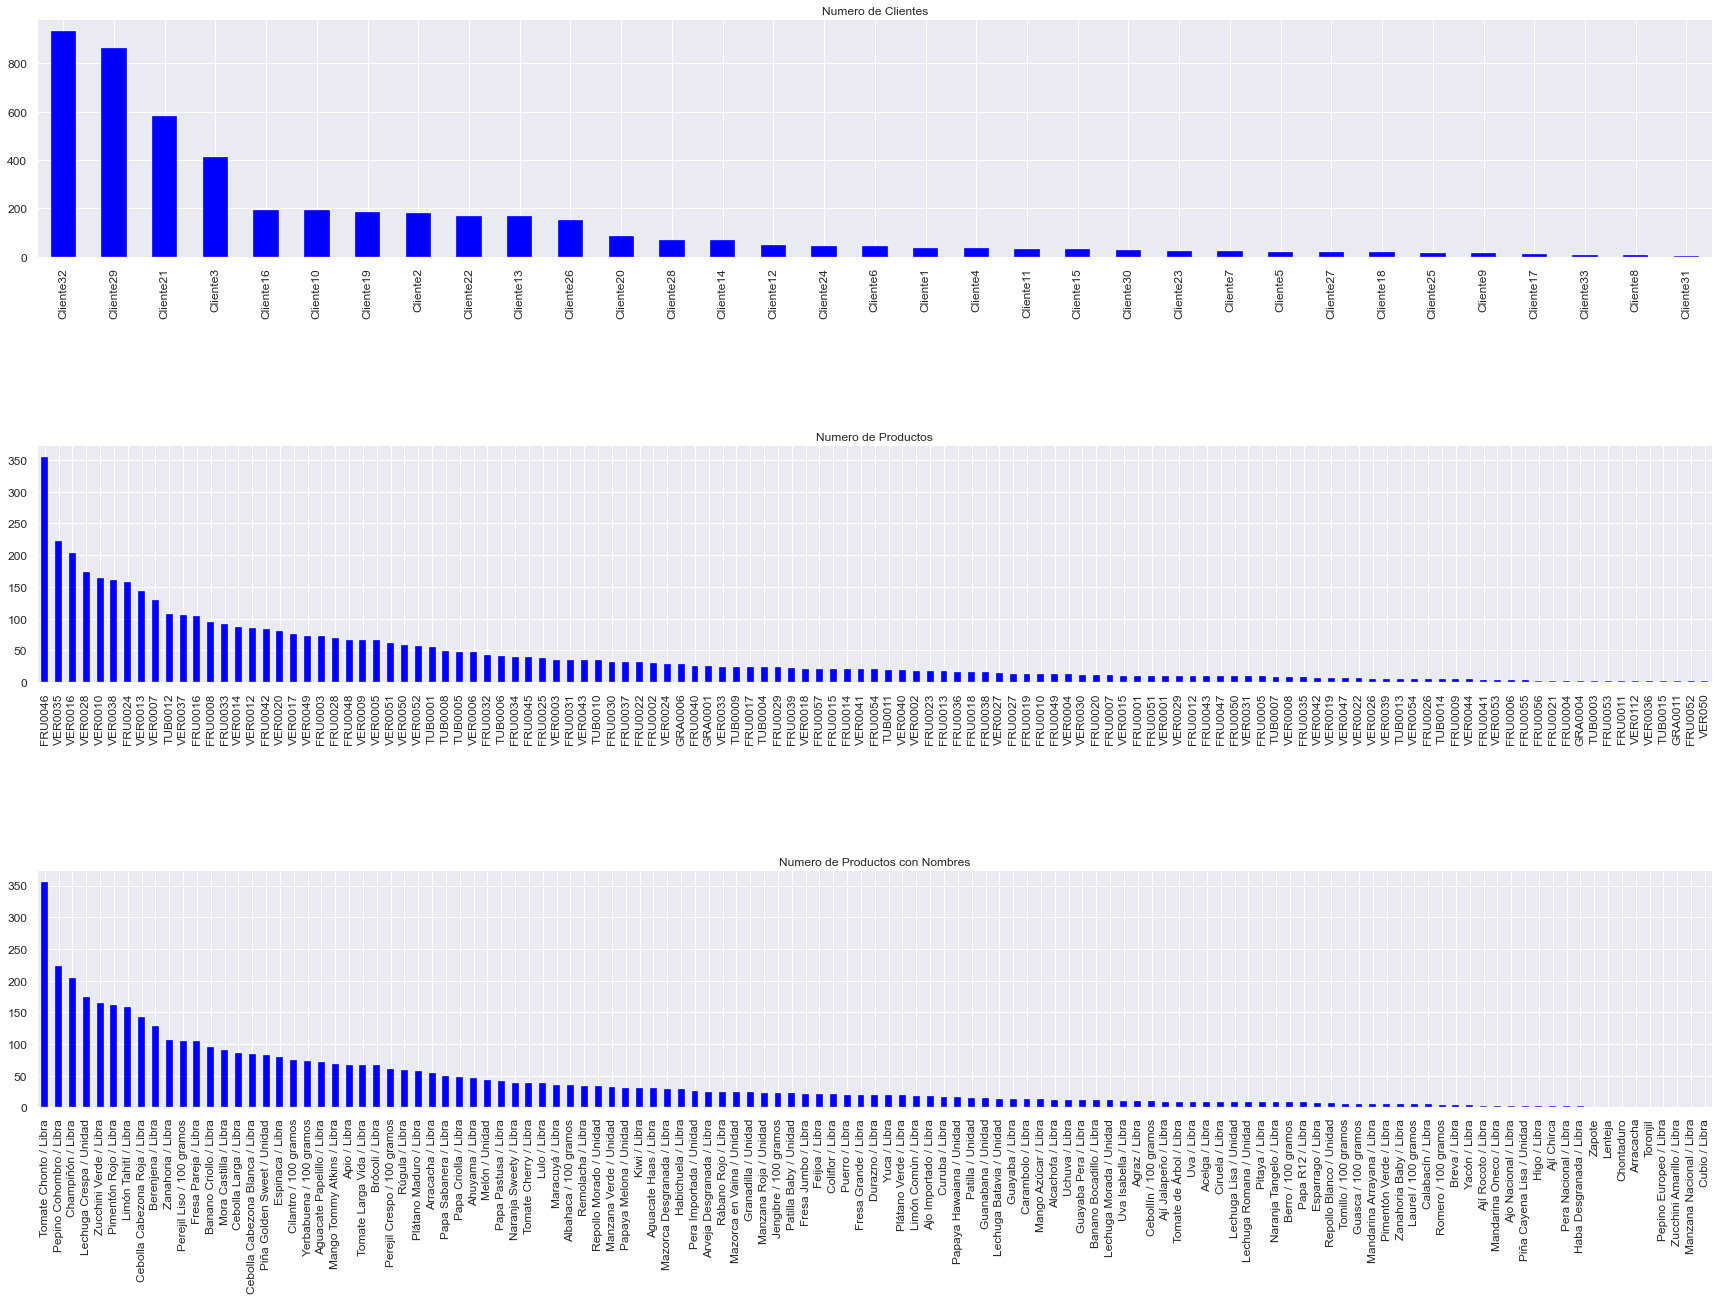

In [12]:
# Se crean las tablas, sumando los valores que se tienen para cada categoria
Cli = pd.DataFrame(data["Cliente"].value_counts())
Pro = pd.DataFrame(data["Producto"].value_counts())
NP = pd.DataFrame(data["Nombre_producto"].value_counts())

# Creamos la figura donde dibujaremos las graficas
fig , axarr = plt.subplots(3,1,figsize=(30,20))

# Dibujamos cada grafica
Cli["Cliente"].plot.bar(ax=axarr[0],fontsize=12,title="Numero de Clientes",color="blue")
Pro["Producto"].plot.bar(ax=axarr[1],fontsize=12,title="Numero de Productos",color = "blue")
NP["Nombre_producto"].plot.bar(ax=axarr[2],fontsize=12,title="Numero de Productos con Nombres",color="blue")

# Cambiamos el espaciamiento entre las graficas
plt.subplots_adjust(hspace=.8);

Podemos observar que hay demasiados tipos de productos (221) y hay productos en los cuales solo se han hecho pedidos esporadicos, por esto se hará necesario centrarnos en el analisis/predicción de las los productos que consideraremos "importantes".

## 1.4 Extracción de Series de Tiempo de Productos Relevantes

Agruparemos nuestros datos por producto y evaluaremos la media del numero de pedidos y su precio:

In [13]:
df=data.groupby(by="Producto").sum().sort_values(by="Precio", ascending=False)
df.head(10)

Pedido   Precio
Producto                 
VER0016      547  1505800
FRU0046     4000   531550
VER0051      160   365900
FRU0042      110   292980
VER0028     1094   271300
VER0038     1324   266750
VER0010     1211   218500
VER0013      858   217800
FRU0032       45   207700
VER0035     1360   207550

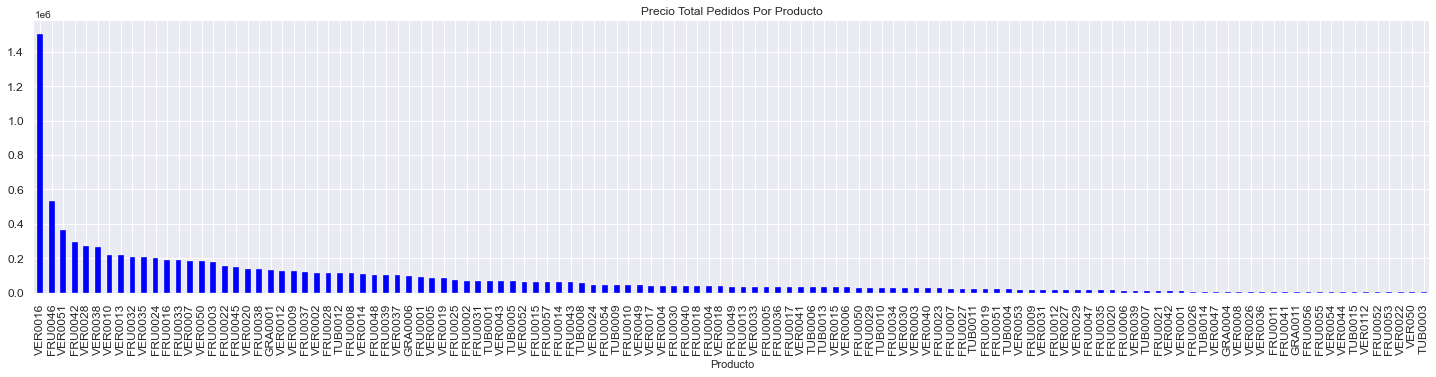

In [14]:
df["Precio"].plot.bar(fontsize=12,title="Precio Total Pedidos Por Producto",color="blue",figsize=(25,5));

In [15]:
df[df.Pedido<10]

Pedido  Precio
Producto                
VER0019        7   82800
FRU0004        2   36000
FRU0050        9   28950
VER0053        4   17700
FRU0021        2    6400
TUB0014        8    6000
GRA0004        3    4700
VER0036        3    4000
FRU0011        3    3920
FRU0041        5    3200
GRA0011        3    3000
FRU0056        2    3000
VER0054        9    3000
VER0112        1    2500
FRU0052        3    2400
FRU0053        1    2000
VER050         1    1500
TUB0003        1     800

Realizaremos un analisis de Pareto para observar las distribuciones y capturar solamente las variables que representen el 80% del volumen de ventas y que tengan mas de 20 pedidos en la linea de tiempo, con el fin de que la prediccion de haga sobre los productos cuyas perdidas impacten economicamente en gran medida.

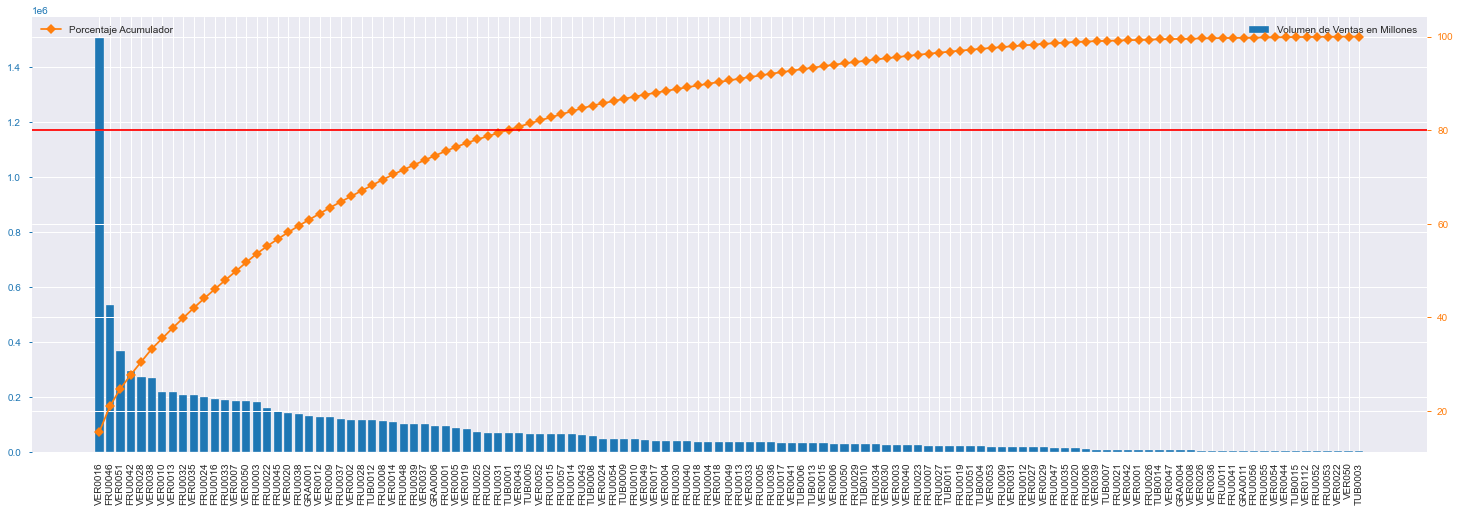

In [16]:
import matplotlib.ticker as mtick

df["cumpercentage"] = df["Precio"].cumsum()/df["Precio"].sum()*100

fig, ax = plt.subplots(figsize=(25,8))
ax.bar(df.index, df.Precio, color="C0",label="Volumen de Ventas en Millones")
ax2 = ax.twinx()
ax2.plot(df.index, df["cumpercentage"], color="C1", marker="D", ms=7,label="Porcentaje Acumulador")
ax2.axhline(80, color='r', linestyle='-')

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
ax.tick_params(axis="x", rotation=90)

ax.legend()
ax2.legend()

plt.show();

In [17]:
df.head()

Pedido   Precio  cumpercentage
Producto                                
VER0016      547  1505800      15.471745
FRU0046     4000   531550      20.933298
VER0051      160   365900      24.692836
FRU0042      110   292980      27.703137
VER0028     1094   271300      30.490682

In [18]:
df[(df.cumpercentage<=80) & (df.Pedido>20)].head(10)

Pedido   Precio  cumpercentage
Producto                                
VER0016      547  1505800      15.471745
FRU0046     4000   531550      20.933298
VER0051      160   365900      24.692836
FRU0042      110   292980      27.703137
VER0028     1094   271300      30.490682
VER0038     1324   266750      33.231476
VER0010     1211   218500      35.476513
VER0013      858   217800      37.714357
FRU0032       45   207700      39.848427
VER0035     1360   207550      41.980955

In [19]:
var_red=df[(df.cumpercentage<=80) & (df.Pedido>20)].index
var_red

Index(['VER0016', 'FRU0046', 'VER0051', 'FRU0042', 'VER0028', 'VER0038',
       'VER0010', 'VER0013', 'FRU0032', 'VER0035', 'FRU0024', 'FRU0016',
       'FRU0033', 'VER0007', 'VER0050', 'FRU0003', 'FRU0022', 'FRU0045',
       'VER0020', 'GRA0001', 'VER0012', 'VER0009', 'FRU0037', 'FRU0028',
       'TUB0012', 'FRU0008', 'VER0014', 'FRU0048', 'FRU0039', 'VER0037',
       'GRA0006', 'FRU0001', 'VER0005', 'FRU0025', 'FRU0002', 'FRU0031'],
      dtype='object', name='Producto')

In [20]:
len(var_red)

36

De esta manera podemos extraer los tipos de producto que que representan el 80% de las compras de los clientes.

Ahora, prodeceremos a extraer las series para colocarlas en un diccionario, cambiarlas el formato a *datetime*, realizar un resampling semanal y finalmente imputar los missing values (naturales y producto del resampling) interpolando con el metodo *time*:

In [21]:
Series = {}
i=0
for prod in var_red:
    Series[prod] = pd.DataFrame(data.loc[data.Producto==var_red[i],["Fecha","Pedido"]])
    Series[prod]["Fecha"] = pd.to_datetime(Series[prod]["Fecha"])
    Series[prod].set_index('Fecha',inplace=True)
    Series[prod]=Series[prod].sort_index(ascending=True)
    Series[prod]=Series[prod].resample("w").mean()
    Series[prod] = Series[prod].assign(Pedido_int=Series[prod].Pedido.interpolate(method='time'))
    Series[prod]=Series[prod].drop(['Pedido'], axis=1)
    Series[prod].rename(columns={'Pedido_int':'Pedido'},inplace=True)
    
    i=i+1

In [22]:
Series["VER0007"].head(10)

Pedido
Fecha               
2016-01-17  2.000000
2016-01-24  3.500000
2016-01-31  5.000000
2016-02-07  6.500000
2016-02-14  8.000000
2016-02-21  7.444444
2016-02-28  6.888889
2016-03-06  6.333333
2016-03-13  5.777778
2016-03-20  5.222222

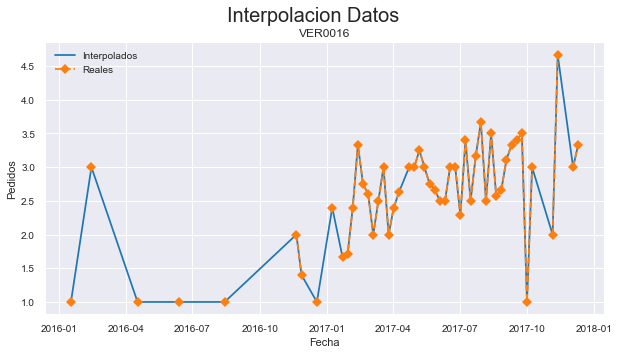

In [164]:
fig, ax1 = plt.subplots(figsize=(10,5))

fig.suptitle('Interpolacion Datos ',fontsize=20)

# Plot de los resultados del la NN
ax1.plot(Series["VER0016"], label='Interpolados')
ax1.plot(a, marker='D',linestyle='--', label='Reales')
ax1.set(title = "VER0016",
   xlabel = "Fecha",
   ylabel = "Pedidos")
ax1.legend();

Graficaremos ahora las Series de tiempo de los productos considerados relevantes:

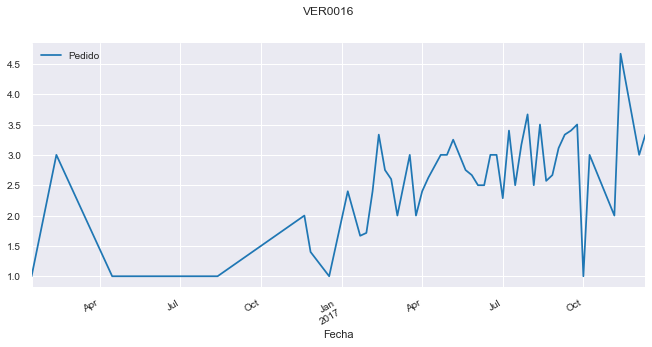

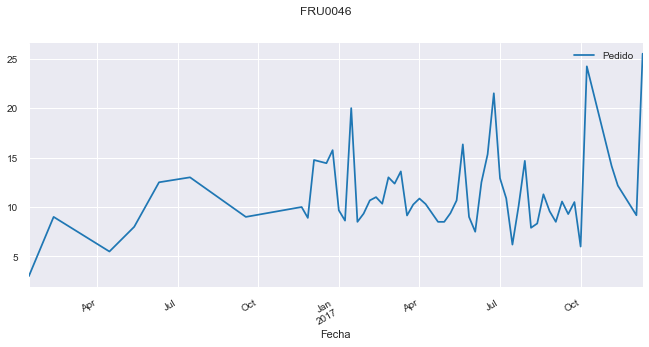

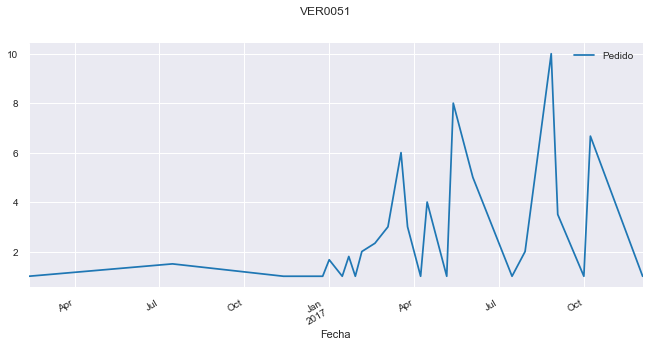

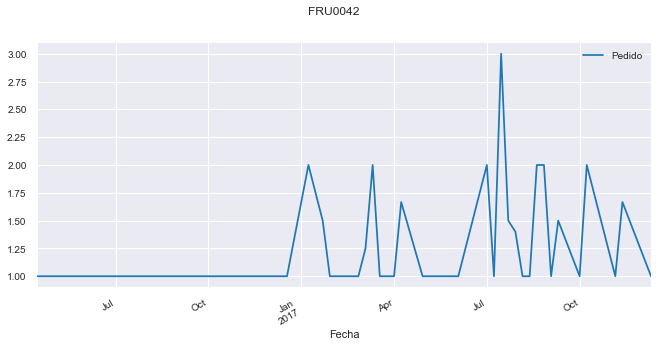

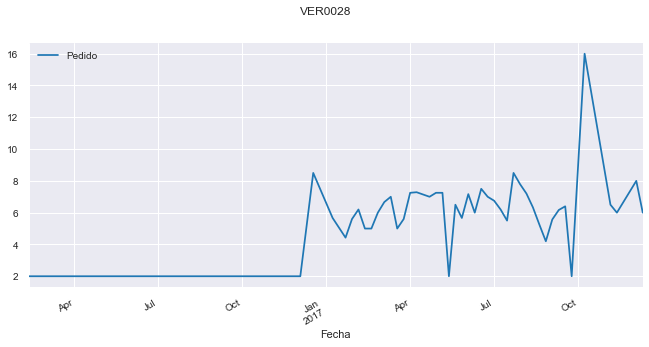

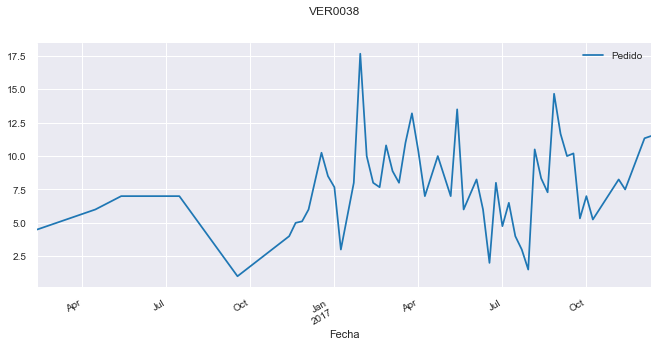

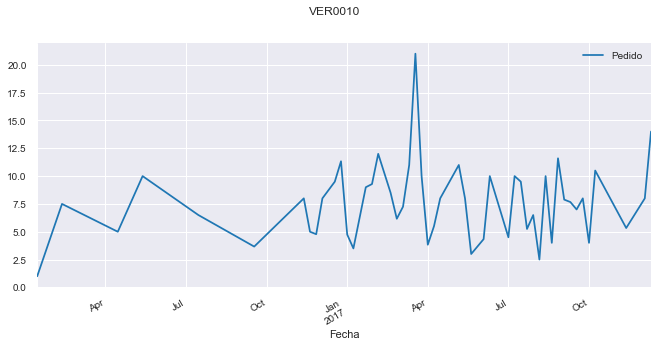

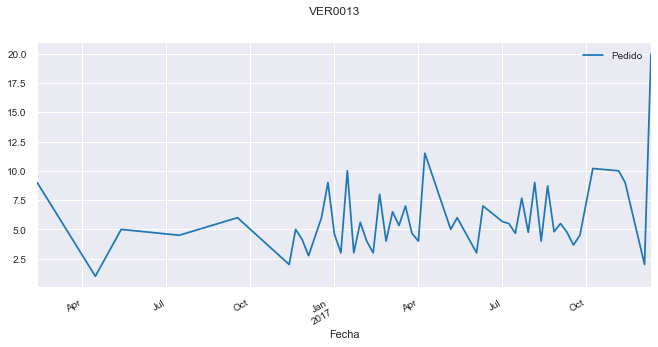

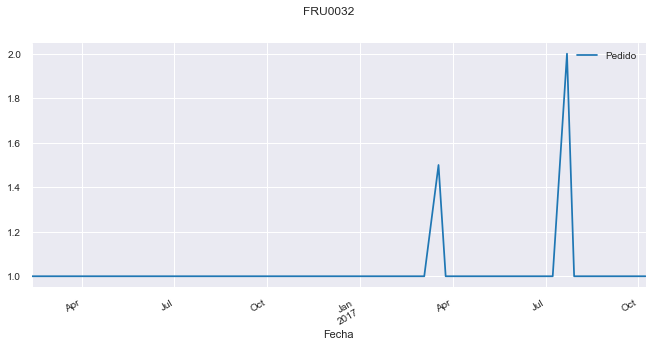

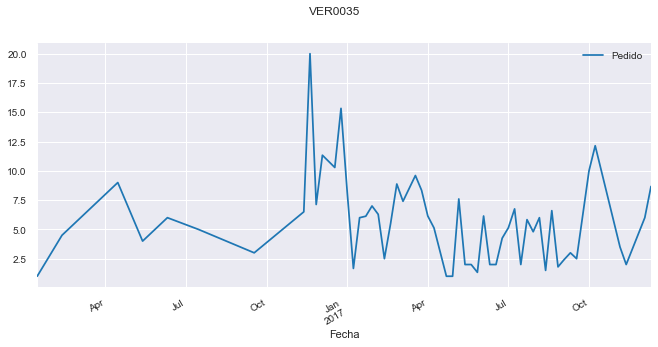

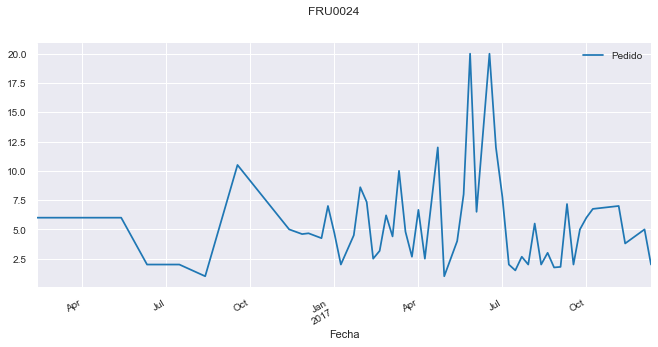

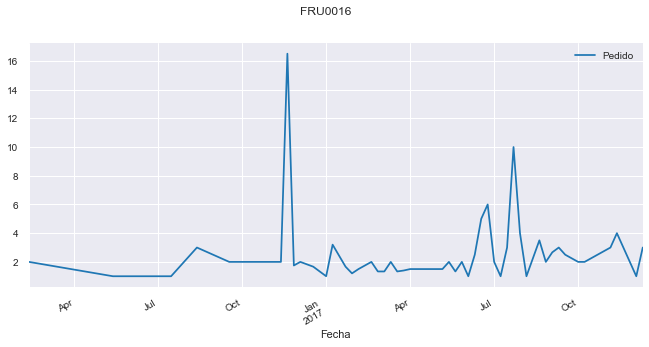

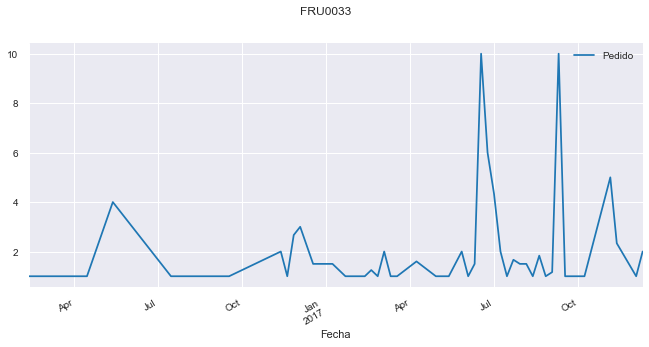

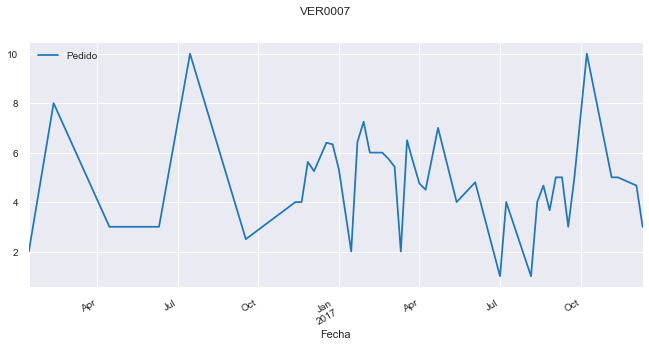

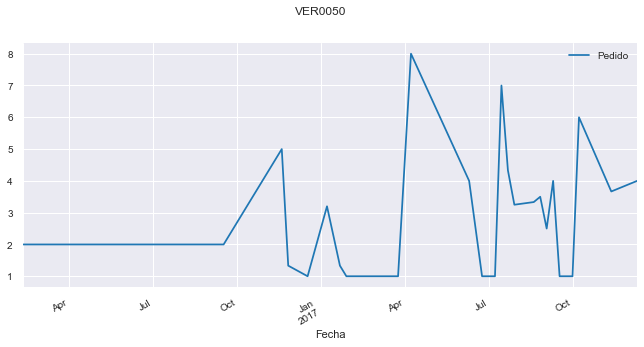

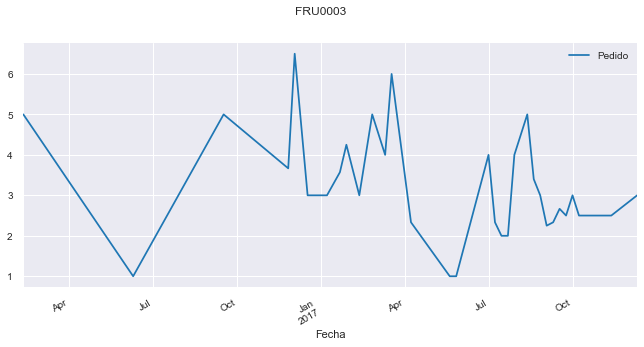

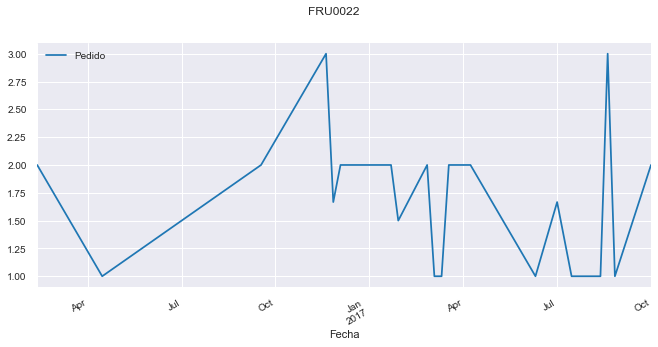

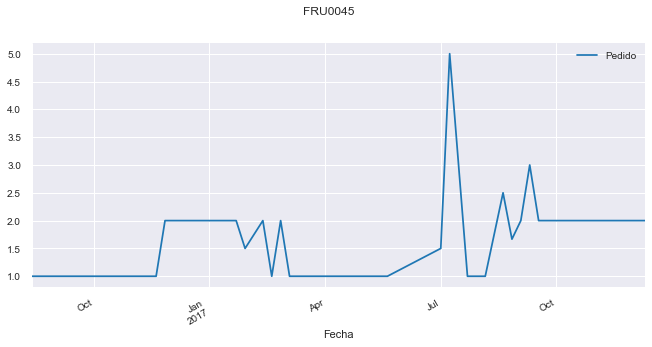

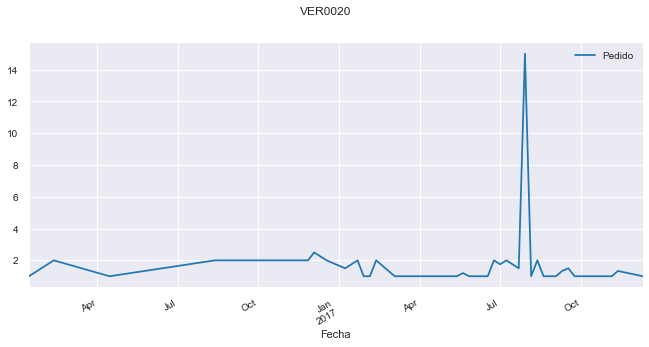

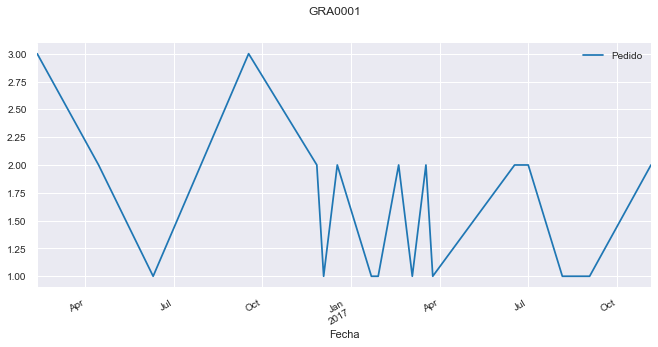

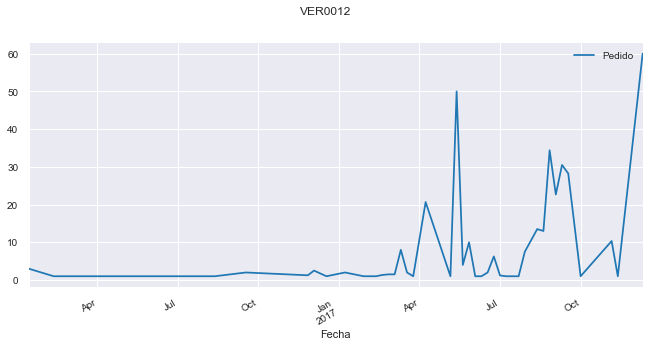

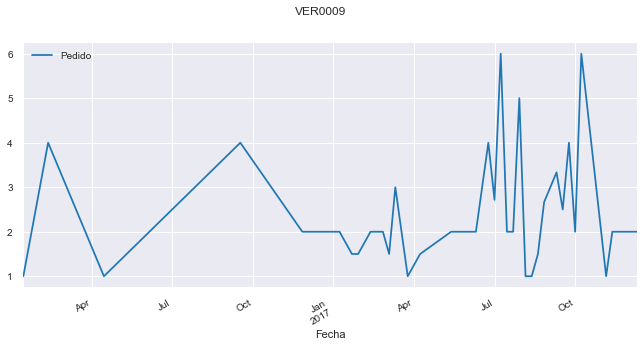

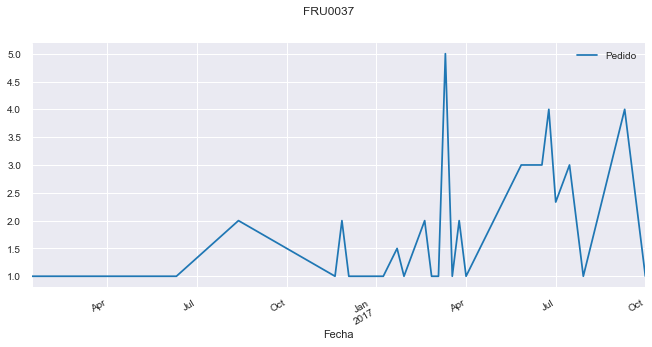

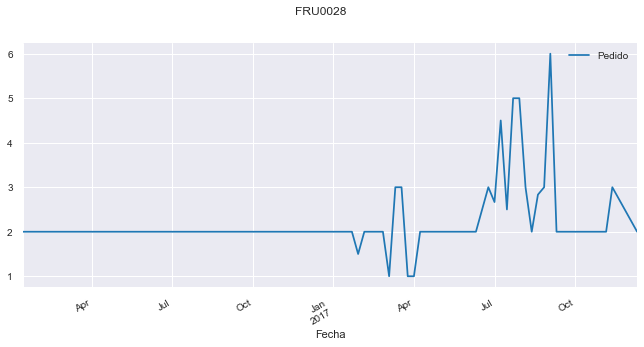

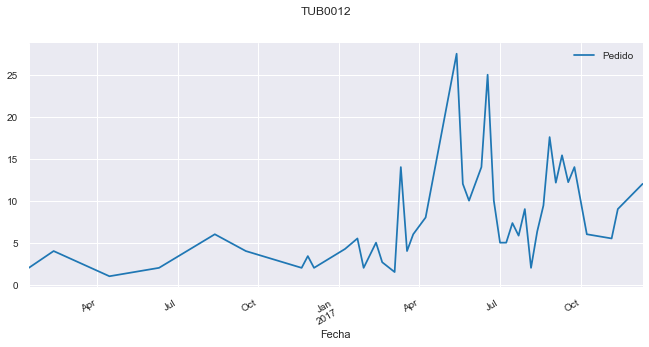

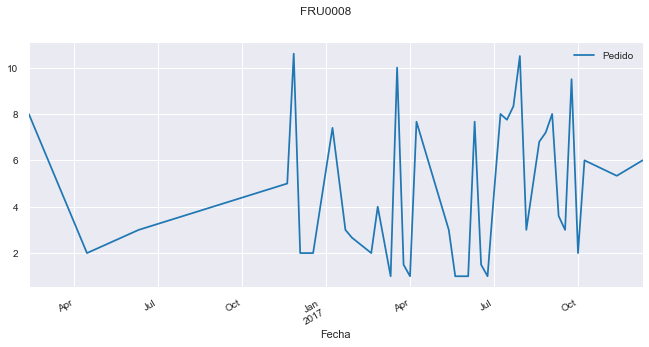

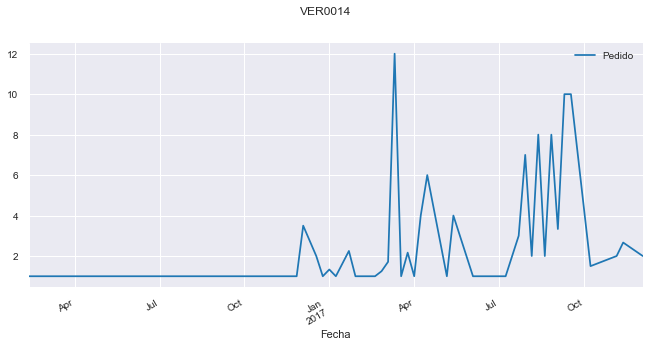

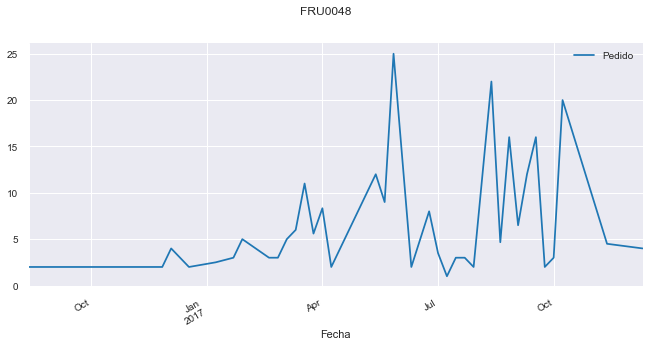

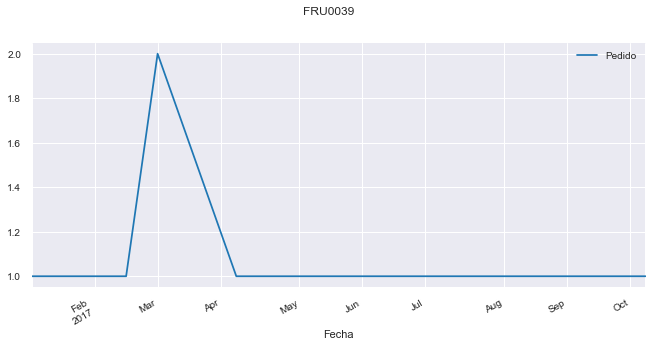

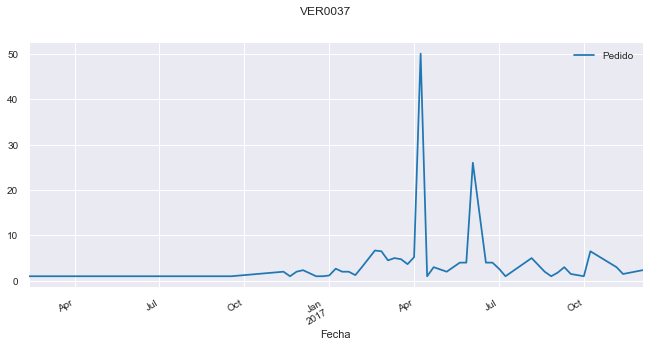

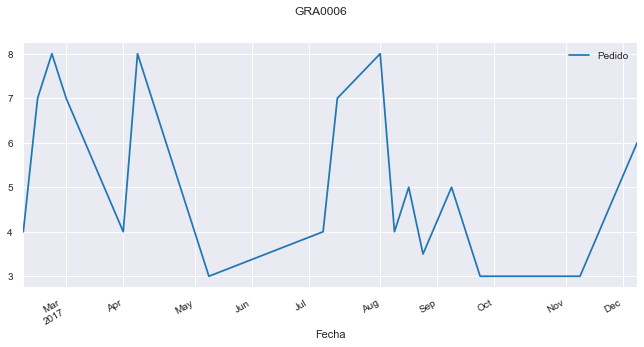

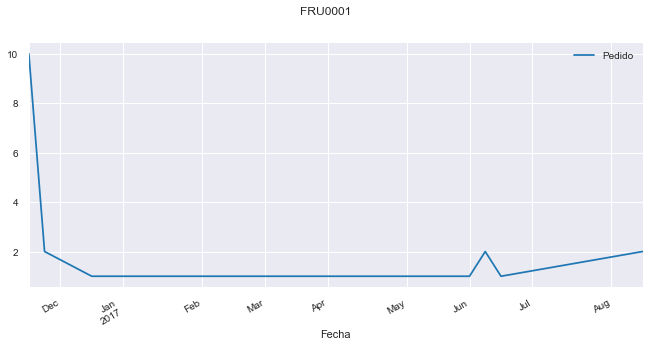

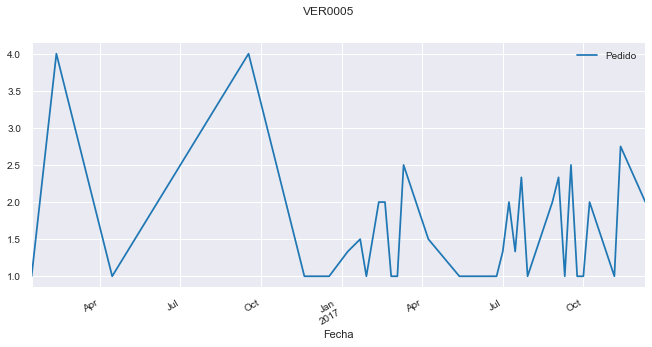

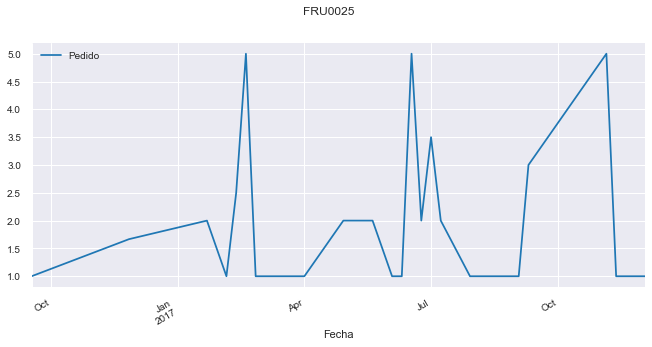

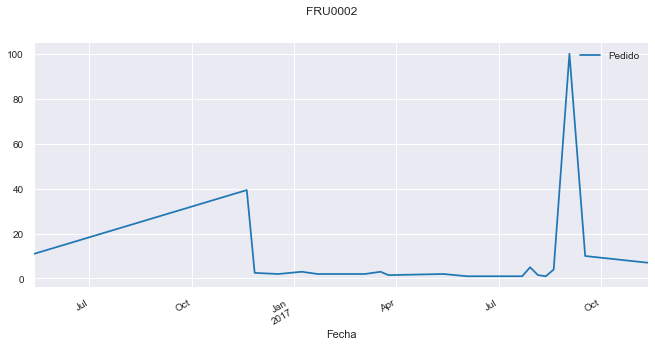

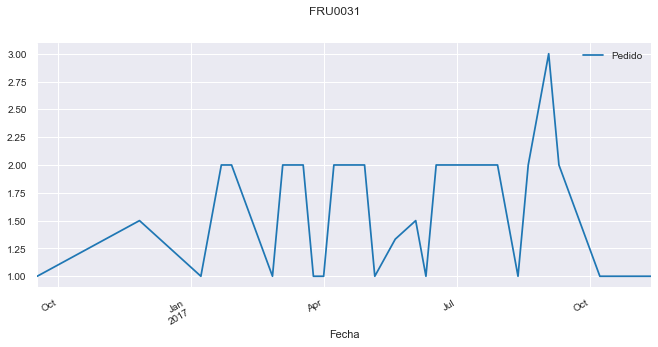

In [23]:
plt.rcParams.update({'figure.max_open_warning': 0})

for prod in var_red:
    ax = Series[prod].plot(linestyle='-', figsize=(11, 5), subplots=True,title=prod);

# 2. Modelos de Prediccion

Generaremos una función de evaluación para diferentes productos que usará tres modelos:

* Una red neuronal densamente conectada.
* Una red de neuronas tipo LSTM
* Modelo Prophet

Esta funcion nos arrojará el MSE (metrica seleccionada para la evaluacion de los modelos) y una visualizacion de la data de test y la predicha.

In [123]:
def eval_prod(producto):
    
    p=producto
    producto=Series[producto]
    
    # Hallamos la fecha correspondiente al punto de separacion del 30% Test y 70%Train
    loc_split=int(producto.index.shape[0]*0.8)
    t_split=producto.index[loc_split]
    
    #------------- Evaluacion con NN ------------------#
    train = producto.loc[:t_split]
    test = producto.loc[t_split:]
    
    # Escalamos los datos de train y test a [-1, 1]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_sc = scaler.fit_transform(pd.DataFrame(train))
    test_sc = scaler.transform(pd.DataFrame(test))
                        
    # Separamos X y Y
    X_train = train_sc[:-1]
    y_train = train_sc[1:]

    X_test = test_sc[:-1]
    y_test = test_sc[1:]
    
    nn_model = Sequential()
    nn_model.add(Dense(2, input_dim=1, activation='selu'))
    nn_model.add(Dense(4, input_dim=1))
    #nn_model.add(Dense(32, input_dim=1))
    nn_model.add(Dense(4, input_dim=1))
    nn_model.add(Dense(2, input_dim=1))
    nn_model.add(Dense(1))
    nn_model.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=2, verbose=0)
    history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0, callbacks=[early_stop], shuffle=False)
    
    #------------- Evaluacion con LSTM ------------------#

    # Preparacion de los datos para el formato de lectura de la red
    train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
    test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

    for s in range(1,2):
        train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
        test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

    X_train = train_sc_df.dropna().drop('Y', axis=1)
    y_train = train_sc_df.dropna().drop('X_1', axis=1)

    X_test = test_sc_df.dropna().drop('Y', axis=1)
    y_test = test_sc_df.dropna().drop('X_1', axis=1)

    X_train = X_train.values#.as_matrix()
    y_train = y_train.values#.as_matrix()

    X_test = X_test.values#.as_matrix()
    y_test = y_test.values#.as_matrix()
    
    X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Generamos la Arquitectura de la LSTM
    lstm_model = Sequential()
    lstm_model.add(Bidirectional(LSTM(2, input_shape=(1, X_train_lmse.shape[1]), activation='selu', kernel_initializer='lecun_uniform', return_sequences=True)))
    lstm_model.add(Bidirectional(LSTM(4,return_sequences=True)))
    lstm_model.add(Bidirectional(LSTM(4,return_sequences=True)))
    lstm_model.add(Bidirectional(LSTM(8,return_sequences=True)))
    lstm_model.add(Bidirectional(LSTM(2)))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer="adam")
    early_stop = EarlyStopping(monitor='loss', patience=2, verbose=0)
    history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=1, verbose=0, shuffle=False, callbacks=[early_stop])

    # Realizamos la prediccion sobre el test
    nn_y_pred_test = scaler.inverse_transform(nn_model.predict(X_test))
    y_pred_test_lstm = scaler.inverse_transform(lstm_model.predict(X_test_lmse))
    
    #------------- Evaluacion con Prophet ------------------#

    # Separamos la serie en Train y Test
    test = producto[producto.index>=t_split]
    train= producto[producto.index<t_split]
    train=train.reset_index()
    test=test.reset_index()
    
    # Cambiamos el formato del dataframe para que Prophet lo reciba
    train=train.rename(columns={'Fecha': 'ds','Pedido':'y'},inplace=False)
    
    # Instanciamos el modelo
    proph_model = Prophet(daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=True
           )
    proph_model.fit(train)
    
    # Generamos las fechas para hacer la prediccion: tamaño y frecuencia
    future = proph_model.make_future_dataframe(periods=len(test), freq='W')
    
    # Generamos la prediccion
    forecast = proph_model.predict(future)
    
    #-------------------Graficas De Los Resultados---------------------
    
    desc=data.loc[data.Producto==p,"Nombre_producto"].reset_index(drop=True)[0]
    
    # Creacion de la figura sobre la cual se harán las graficas
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20, 7))
    fig.suptitle('Pruebas De Modelos Para ' + desc,fontsize=20)
    
    # Plot de los resultados del la NN
    ax1.plot(scaler.inverse_transform(y_test), label='True')
    ax1.plot(nn_y_pred_test, label='NN')
    ax1.set(title = "NN Dense",
       xlabel = "Date",
       ylabel = "Pedidos")
    ax1.legend()

    # Plot de los resultados del la red LSTM
    ax2.plot(scaler.inverse_transform(y_test), label='True')
    ax2.plot(y_pred_test_lstm, label='LSTM')
    ax2.set(title = "LSTM",
       xlabel = "Date",
       ylabel = "Pedidos")
    ax2.legend()
    
    # Plot de los resultados del Prophet
    ax3.plot(test.Fecha,test.Pedido,label="True")
    ax3.plot(forecast[forecast.ds>=t_split].ds,forecast[forecast.ds>=t_split].yhat,label="Prophet")
    ax3.set(title = "Prophet",
       xlabel = "Date",
       ylabel = "Pedidos")
    ax3.legend()

    # Evaluacion de las metricas de cada modelo
    nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
    lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
    ph_test_mse=mean_squared_error(test.Pedido,forecast[forecast.ds>=t_split].yhat)
    
    # Seleccionar el modelo de menor MSE
    if ((nn_test_mse<lstm_test_mse)&(nn_test_mse<ph_test_mse)):
        model_final = nn_model
        tipo="NN"        
    else:
        if((lstm_test_mse<nn_test_mse)&(lstm_test_mse<ph_test_mse)):
            model_final = lstm_model
            tipo="LSTM"
        else:
            model_final = proph_model
            tipo="Pro"
           
    print('\nMSE NN: %f'%nn_test_mse)
    print('MSE LSTM: %f'%lstm_test_mse)
    print('MSE Prophet: %f'%ph_test_mse)
    
    # Guardamos el mejor modelo con el nombre del producto y con el tipo del producto
    pathr =('Modelo_'+p+'_'+tipo+'.h5')
    model_final.save(pathr) 
    
    return model_final

19/19 [==============================] - 0s 2ms/step - loss: 1.2431

MSE NN: 0.671474
MSE LSTM: 1.243078
MSE Prophet: 11.184054


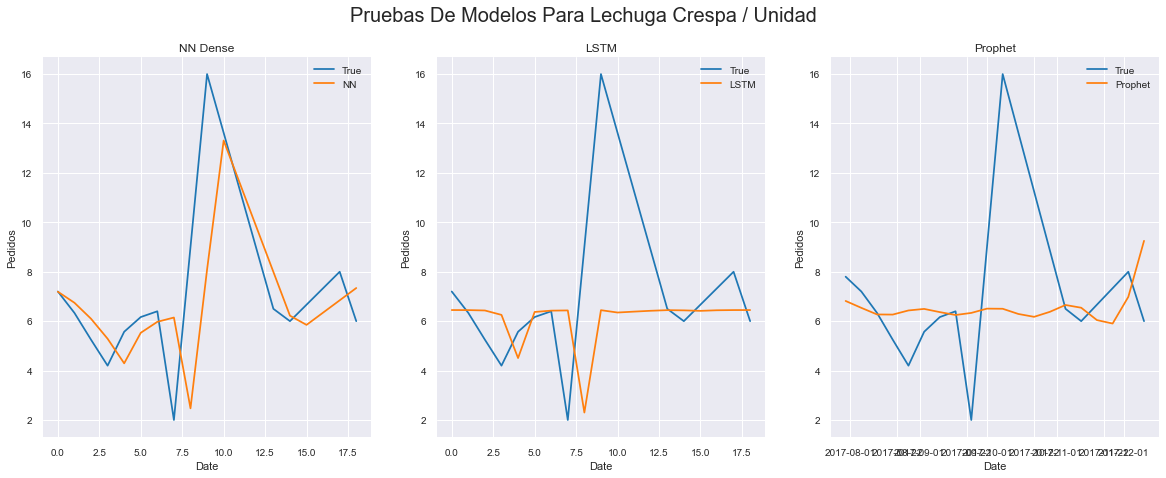

In [124]:
model_FRU0028 = eval_prod("VER0028")

Cargue de los modelos de prediccion de cada producto:

In [128]:
Modelo_FRU0003_NN = load_model('Modelo_FRU0003_NN.h5')
Modelo_FRU0022_LSTM = load_model('Modelo_FRU0022_LSTM.h5')
Modelo_FRU0033_NN = load_model('Modelo_FRU0033_NN.h5')
Modelo_FRU0037_LSTM = load_model('Modelo_FRU0037_LSTM.h5')
Modelo_FRU0045_NN = load_model('Modelo_FRU0045_NN.h5')
Modelo_GRA0001_LSTM = load_model('Modelo_GRA0001_LSTM.h5')
Modelo_VER0007_LSTM = load_model('Modelo_VER0007_LSTM.h5')
Modelo_VER0009_NN = load_model('Modelo_VER0009_NN.h5')
Modelo_VER0012_LSTM = load_model('Modelo_VER0012_LSTM.h5')
Modelo_VER0020_LSTM = load_model('Modelo_VER0020_LSTM.h5')
Modelo_VER0050_LSTM = load_model('Modelo_VER0050_LSTM.h5')
ModelosAvanzados2FRU0016_LSTM = load_model('ModelosAvanzados2FRU0016_LSTM.h5')
ModelosAvanzados2FRU0046_NN = load_model('ModelosAvanzados2FRU0046_NN.h5')
ModelosAvanzados2VER0051_LSTM = load_model('ModelosAvanzados2VER0051_LSTM.h5')
ModelosAvanzados2VER0038_NN = load_model('ModelosAvanzados2VER0038_NN.h5')
ModelosAvanzados2VER0010_NN = load_model('ModelosAvanzados2VER0010_NN.h5')
ModelosAvanzados2VER0013_NN = load_model('ModelosAvanzados2VER0013_NN.h5')
ModelosAvanzados2VER0035_LSTM = load_model('ModelosAvanzados2VER0035_LSTM.h5')
ModelosAvanzados2FRU0024_NN = load_model('ModelosAvanzados2FRU0024_NN.h5')
ModelosAvanzados2FRU0042_NN = load_model('ModelosAvanzados2FRU0042_NN.h5')
ModelosAvanzados2FRU0032_NN = load_model('ModelosAvanzados2FRU0032_NN.h5')
Modelo_VER0016_NN = load_model('Modelo_VER0016_NN.h5')
Modelo_VER0028_NN = load_model('Modelo_VER0028_NN.h5')
Modelo_FRU0028_LSTM = load_model('Modelo_FRU0028_LSTM.h5')
Modelo_TUB0012_LSTM = load_model('Modelo_TUB0012_LSTM.h5')
Modelo_FRU0008_NN = load_model('Modelo_FRU0008_NN.h5')
Modelo_VER0014_LSTM = load_model('Modelo_VER0014_LSTM.h5')
Modelo_FRU0048_LSTM = load_model('Modelo_FRU0048_LSTM.h5')
Modelo_FRU0039_LSTM = load_model('Modelo_FRU0039_LSTM.h5')
Modelo_VER0037_LSTM = load_model('Modelo_VER0037_LSTM.h5')
Modelo_GRA0006_LSTM = load_model('Modelo_GRA0006_LSTM.h5')
Modelo_FRU0001_LSTM = load_model('Modelo_FRU0001_LSTM.h5')
Modelo_VER0005_NN = load_model('Modelo_VER0005_NN.h5')
Modelo_FRU0025_NN = load_model('Modelo_FRU0025_NN.h5')
Modelo_FRU0002_NN = load_model('Modelo_FRU0002_NN.h5')
Modelo_FRU0031_NN = load_model('Modelo_FRU0031_NN.h5')

Creamos una funcion que calcule la demanda de un producto

In [132]:
def pred_dem(producto):
    
    # Creamos un diccionario con los modelos
    modelos = {
        "VER0016":("N",Modelo_VER0016_NN), "FRU0046":("N",ModelosAvanzados2FRU0046_NN), "VER0051":("L",ModelosAvanzados2VER0051_LSTM), "FRU0042":("N",ModelosAvanzados2FRU0042_NN),
        "VER0028":("N",Modelo_VER0028_NN), "VER0038":("N",ModelosAvanzados2VER0038_NN), "VER0010":("N",ModelosAvanzados2VER0010_NN), "VER0013":("N",ModelosAvanzados2VER0013_NN),
        "FRU0032":("N",ModelosAvanzados2FRU0032_NN), "VER0035":("L",ModelosAvanzados2VER0035_LSTM), "FRU0024":("N",ModelosAvanzados2FRU0024_NN),
        
        
        "FRU0016":("L",ModelosAvanzados2FRU0016_LSTM),
        "FRU0033":("N",Modelo_FRU0033_NN), "VER0007":("L",Modelo_VER0007_LSTM), "VER0050":("L",Modelo_VER0050_LSTM), "FRU0003":("N",Modelo_FRU0003_NN),
        "FRU0022":("L",Modelo_FRU0022_LSTM), "FRU0045":("N",Modelo_FRU0045_NN), "VER0020":("L",Modelo_VER0020_LSTM), "GRA0001":("L",Modelo_GRA0001_LSTM),
        "VER0012":("L",Modelo_VER0012_LSTM), "VER0009":("N",Modelo_VER0009_NN), "FRU0037":("L",Modelo_FRU0037_LSTM),
        
        
        
        
        "FRU0028":("L",Modelo_FRU0028_LSTM),
        "TUB0012":("L",Modelo_TUB0012_LSTM), "FRU0008":("N",Modelo_FRU0008_NN), "VER0014":("L",Modelo_VER0014_LSTM), "FRU0048":("L",Modelo_FRU0048_LSTM),
        "FRU0039":("L",Modelo_FRU0039_LSTM), "VER0037":("L",Modelo_VER0037_LSTM), "GRA0006":("L",Modelo_GRA0006_LSTM), "FRU0001":("L",Modelo_FRU0001_LSTM),
        "VER0005":("N",Modelo_VER0005_NN), "FRU0025":("N",Modelo_FRU0025_NN), "FRU0002":("N",Modelo_FRU0002_NN), "FRU0031":("N",Modelo_FRU0031_NN)
    }
    
    desc=data.loc[data.Producto==producto,"Nombre_producto"].reset_index(drop=True)[0]
    mod=modelos[producto][1]
    t_mod=modelos[producto][0]
    
    if t_mod=="N":
        
        df_to_scal = Series[producto]
        other = pd.DataFrame([0], columns=['Pedido'], index=[df_to_scal.tshift().index[-1]])
        df_to_scal=df_to_scal.append(other)
        scaler = MinMaxScaler(feature_range=(-1, 1))
        df_scal = scaler.fit_transform(pd.DataFrame(df_to_scal))

        X_Pred = df_scal[:-1][-1]
        nn_y_pred_test = scaler.inverse_transform(mod.predict(X_Pred))
        
        X_Pred = other.index
        y_Pred=nn_y_pred_test[0][0]
    
    if t_mod=="L":
        
        df_to_scal = Series[producto]
        other = pd.DataFrame([0], columns=['Pedido'], index=[df_to_scal.tshift().index[-1]])
        df_to_scal=df_to_scal.append(other)
        scaler = MinMaxScaler(feature_range=(-1, 1))
        df_scal = scaler.fit_transform(pd.DataFrame(df_to_scal))
        
        # Preparacion de los datos para el formato de lectura de la red
        test_sc_df = pd.DataFrame(df_scal, columns=['Y'], index=df_to_scal.index)

        for s in range(1,2):
            test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

        X_test = test_sc_df.dropna().drop('Y', axis=1)
        X_test = X_test.values#.as_matrix()
        X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        
        y_pred_test_lstm = scaler.inverse_transform(mod.predict(X_test_lmse))
        
        X_Pred = other.index
        y_Pred = y_pred_test_lstm[-1][0]
        
    if t_mod=="P":
        
        # Separamos la serie en Train y Test
        df=Series[producto]
        
        df=df.reset_index()

        # Cambiamos el formato del dataframe para que Prophet lo reciba
        df=df.rename(columns={'Fecha': 'ds','Pedido':'y'},inplace=False)
        
        # Instanciamos el modelo
        mod = Prophet(daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=True
               )
        mod.fit(df)

        # Generamos las fechas para hacer la prediccion: tamaño y frecuencia
        future = mod.make_future_dataframe(periods=1, freq='W')

        # Generamos la prediccion
        forecast = mod.predict(future)
        
        # Extraemos los valores de la prediccion
        X_Pred = forecast.ds.iloc[-1]
        y_Pred = forecast.yhat.iloc[-1]
         
    print(" \nPedido Proxima Semana del Producto \n" + desc + "\n%f" %y_Pred + " Unidades")
    
    # Creacion de la figura sobre la cual se harán las graficas
    fig, ax = plt.subplots(figsize=(15, 5))
    fig.suptitle('Demanda Producto \n' + desc,fontsize=15)

    # Plot de los resultados del la NN
    ax.plot(Series[producto], label='Historico Pedidos')
    ax.plot(X_Pred, y_Pred, label='Proximo Pedido',color="C1", marker="D", ms=7)
    ax.set(xlabel = "Date", ylabel = "Pedidos")
    ax.legend()
    
    return modelos;

 
Pedido Proxima Semana del Producto 
Champiñón / Libra
3.196376 Unidades


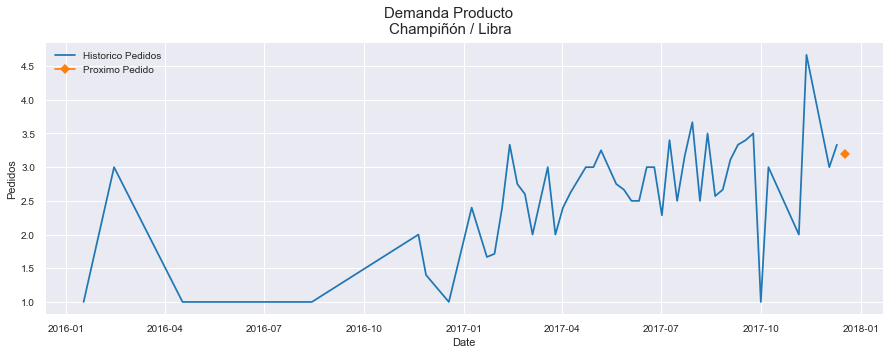

In [138]:
modelos = pred_dem("VER0016")

In [137]:
len(modelos)

36